<a href="https://colab.research.google.com/github/suaviq/diabetic-retinopathy-detection/blob/main/user.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
- imports
- cloning repository with newest model
- class EvaluateModel for predicting result on image/images

In [30]:
# @title Utils, cloning repository and class for evaluating model
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
import numpy as np
import keras.utils as image
from google.colab import files
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import io
import math

In [31]:
# @title Cloning repository and class for evaluating model
! git clone https://github.com/suaviq/diabetic-retinopathy-detection.git

fatal: destination path 'diabetic-retinopathy-detection' already exists and is not an empty directory.


In [32]:
# @title Evaluating model
class EvaluateModel:
    def __init__(self, model_path):
        self.model = tf.keras.models.load_model(model_path)
        self.image_shape = (image_height, image_width, 3)

    def preprocess_image(self, image_path):
        img = tf.keras.utils.load_img(image_path, target_size=self.image_shape)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        return tf.keras.applications.resnet50.preprocess_input(img_array)

    def predict_image(self, image_path):
        preprocessed_image = self.preprocess_image(image_path)
        predictions = self.model.predict(preprocessed_image)
        predictions = tf.nn.sigmoid(predictions)
        predictions = tf.where(predictions < 0.5, 0, 1).numpy()
        return predictions

    def predict_folder(self, folder_path):
        predictions_list = []
        for filename in os.listdir(folder_path):
              image_path = os.path.join(folder_path, filename)
              prediction = self.predict_image(image_path)
              predictions_list.append((filename, prediction))
        return predictions_list

# Load one image and check results
- uploading image to colab
- image must be resized before it goes into model
- checking the result in plot

In [12]:
image_upload = files.upload()

Saving 10125_right.jpeg to 10125_right.jpeg


In [18]:
# @title Resize image for model, trained model summary
file_content = list(image_upload.values())[0]
filename = list(image_upload.keys())[0]
image = Image.open(io.BytesIO(file_content))
image_path = '/content/' + filename
image_path_resized = image_path[:-5] + '_resized.jpeg'
image = Image.open(image_path)
image_resized = image.resize((224, 224))
image_resized.save(image_path_resized)

trained_model = load_model('/content/diabetic-retinopathy-detection/model.h5')
trained_model.summary()
output_shape = trained_model.layers[0].output_shape
image_height = output_shape[0][1]
image_width = output_shape[0][2]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0     

1/1 [==============================] - 1s 1s/step


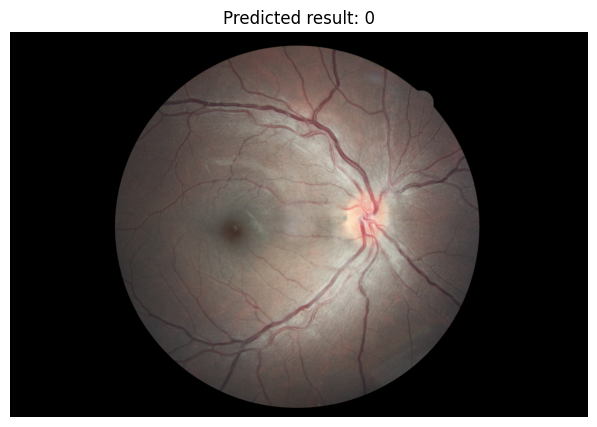

In [6]:
# @title Predicted result on one image
model_path = '/content/diabetic-retinopathy-detection/model.h5'
model_usage = EvaluateModel(model_path)
prediction_result = str(model_usage.predict_image(image_path))

plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.title("Predicted result: " + prediction_result[2])
plt.axis("off")
plt.show()

# Load batch of images
- folder must be zipped
- set show_plot = True/False based whether you would like to see plotted predictions
- predictions are saved to text file

In [7]:
images_folder = files.upload()

Saving test.zip to test.zip


In [8]:
show_plot = True # @param {type:"boolean"}

In [9]:
# @title Unzip folder and create folder with resized images
folder_name = list(images_folder.keys())[0]
! unzip $folder_name
folder_path = '/content/' + folder_name[:-4]
folder_path_resized = folder_path + '_resized'
! mkdir $folder_path_resized
! cp -r $folder_path/* $folder_path_resized
for file in os.listdir(folder_path_resized):
  path = os.path.join(folder_path_resized, file)
  image = Image.open(path)
  image = image.resize((224, 224))
  image.save(path)

Archive:  test.zip
  inflating: test/0_10_left.jpeg     
  inflating: test/0_140_left.jpeg    
  inflating: test/0_23.jpeg          
  inflating: test/0_65_left.jpeg     
  inflating: test/0_66_right.jpeg    
  inflating: test/1_393_right (1).jpeg  
  inflating: test/1_393_right (2).jpeg  
  inflating: test/1_393_right (3).jpeg  
  inflating: test/1_393_right (4).jpeg  


In [10]:
# @title Batch prediction and save results to txt file
folder_predictions = model_usage.predict_folder(folder_path_resized)

output_file = folder_path[9:] + '.txt'
with open(output_file, 'w') as f:
    for filename, prediction in folder_predictions:
      f.write(f"File: {filename}, prediction: {str(prediction)[2]}\n")
    f.close()

if show_plot:
  n = len(folder_predictions)
  subplot_size = math.ceil(math.sqrt(n))

  plt.figure(figsize=(10, 10))
  for i, (filename, prediction) in enumerate(folder_predictions):
      ax = plt.subplot(subplot_size, subplot_size, i + 1)
      show_image = Image.open(os.path.join(folder_path_resized, filename))
      plt.imshow(show_image)
      plt.title(f"File: {filename}, prediction: {str(prediction)[2]}", fontsize = 10)
      plt.axis("off")

  plt.tight_layout()
  plt.show()

1/1 [==============================] - 0s 193ms/step
